In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("C:/Users/DELL/OneDrive/Desktop/College/Study/Year 2/Sem 3/Practicals/Real Estate Predictor/RealEstatePredictor/datasets/noise_quality.csv")


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5005 entries, 0 to 5004
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Station     5005 non-null   object 
 1   Year        5005 non-null   int64  
 2   Month       5005 non-null   int64  
 3   Day         5002 non-null   float64
 4   Night       4995 non-null   float64
 5   DayLimit    5005 non-null   int64  
 6   NightLimit  5005 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 273.8+ KB


In [4]:
df.shape

(5005, 7)

In [23]:
df.describe()

,Year,Month,Day,Night,DayLimit,NightLimit,Date,StationEncoded,DayExcess,NightExcess
count,5005.000000,5005.000000,5002.000000,4.995000e+03,5.005000e+03,5.005000e+03,5005,5005.000000,5.002000e+03,4.995000e+03
mean,2015.195804,6.538462,-0.005475,2.958817e-16,-3.038085e-16,2.952905e-16,2015-08-28 12:25:10.489510656,33.678322,-3.409241e-17,-3.414019e-17
min,2011.000000,1.000000,-2.673341,-4.335684e+00,-1.222151e+00,-1.133406e+00,2011-02-01 00:00:00,0.000000,-3.304651e+00,-3.089023e+00
25%,2014.000000,4.000000,-0.649827,-6.645728e-01,-1.222151e+00,-1.133406e+00,2014-01-01 00:00:00,16.000000,-5.245497e-01,-5.212776e-01
50%,2016.000000,7.000000,0.024677,-1.750913e-01,4.885412e-01,3.415542e-01,2016-01-01 00:00:00,33.000000,9.325053e-02,9.852284e-02
75%,2017.000000,10.000000,0.699181,6.815013e-01,4.885412e-01,3.415542e-01,2017-07-01 00:00:00,51.000000,6.080840e-01,5.412375e-01
max,2018.000000,12.000000,2.722695,5.209205e+00,1.629002e+00,1.816515e+00,2018-12-01 00:00:00,69.000000,4.623785e+00,4.525669e+00
std,2.172061,3.433561,0.971197,1.000100e+00,1.000100e+00,1.000100e+00,NaN,20.190500,1.000100e+00,1.000100e+00


In [5]:
print(df.isnull().sum())

Station        0
Year           0
Month          0
Day            3
Night         10
DayLimit       0
NightLimit     0
dtype: int64


In [6]:
df.dropna(subset=['Day', 'Night'], inplace=False)

,Station,Year,Month,Day,Night,DayLimit,NightLimit
0,BEN01,2011,2,66.0,56.0,55,45
1,BEN01,2011,3,66.0,58.0,55,45
2,BEN01,2011,4,66.0,57.0,55,45
3,BEN01,2011,5,66.0,56.0,55,45
4,BEN01,2011,6,67.0,57.0,55,45
...,...,...,...,...,...,...,...
5000,MUM10,2018,8,73.0,69.0,65,55
5001,MUM10,2018,9,72.0,68.0,65,55
5002,MUM10,2018,10,73.0,68.0,65,55
5003,MUM10,2018,11,72.0,68.0,65,55


In [7]:
print(df.isnull().sum())

Station        0
Year           0
Month          0
Day            3
Night         10
DayLimit       0
NightLimit     0
dtype: int64


In [8]:
# Combining Year and Month into a single column

df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

In [9]:
# Convert Station (string) into numbers using label encoding

le = LabelEncoder()
df['StationEncoded'] = le.fit_transform(df['Station'])

In [10]:
# Columns to show how much the noise exceeds the limit:

df['DayExcess'] = df['Day'] - df['DayLimit']
df['NightExcess'] = df['Night'] - df['NightLimit']


In [11]:
# Scale Features (for ML models)
scaler = StandardScaler()
df[['Day', 'Night', 'DayLimit', 'NightLimit', 'DayExcess', 'NightExcess']] = scaler.fit_transform(
    df[['Day', 'Night', 'DayLimit', 'NightLimit', 'DayExcess', 'NightExcess']]
)

In [12]:
# df.drop(['Year', 'Month', 'Station'], axis=1, inplace=False)

In [13]:
# Feature Selection 

selected_features = ['StationEncoded', 'Day', 'Night', 'DayExcess', 'NightExcess']
df_model = df[selected_features]

In [14]:
# Scaling / Normalization

scaler = StandardScaler()
df_model_scaled = pd.DataFrame(scaler.fit_transform(df_model), columns=selected_features)

In [15]:
X = df_model_scaled.drop('DayExcess', axis=1)  # Features
y = df_model_scaled['DayExcess']              # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Outlier Detection 

Q1 = df['Day'].quantile(0.25)
Q3 = df['Day'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Day'] < lower_bound) | (df['Day'] > upper_bound)]
print(f"Total outliers in Day: {len(outliers)}")


Total outliers in Day: 51


In [17]:
# Outlier Removal

# df = df[(df['Day'] >= lower_bound) & (df['Day'] <= upper_bound)]


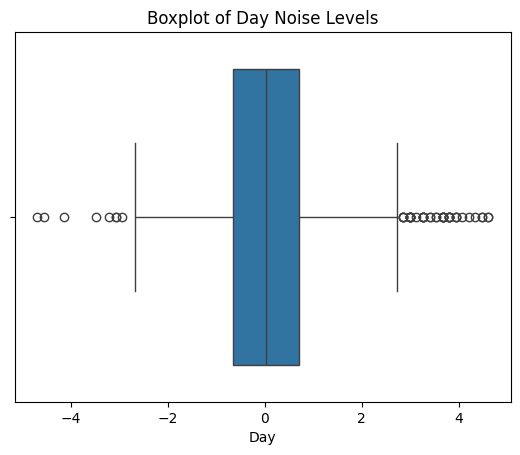

In [18]:
# Visulaizing Outliers

sns.boxplot(x=df['Day'])
plt.title("Boxplot of Day Noise Levels")
plt.show()

In [19]:
# Cap Outliers (instead of removing)

df['Day'] = df['Day'].clip(lower=lower_bound, upper=upper_bound)


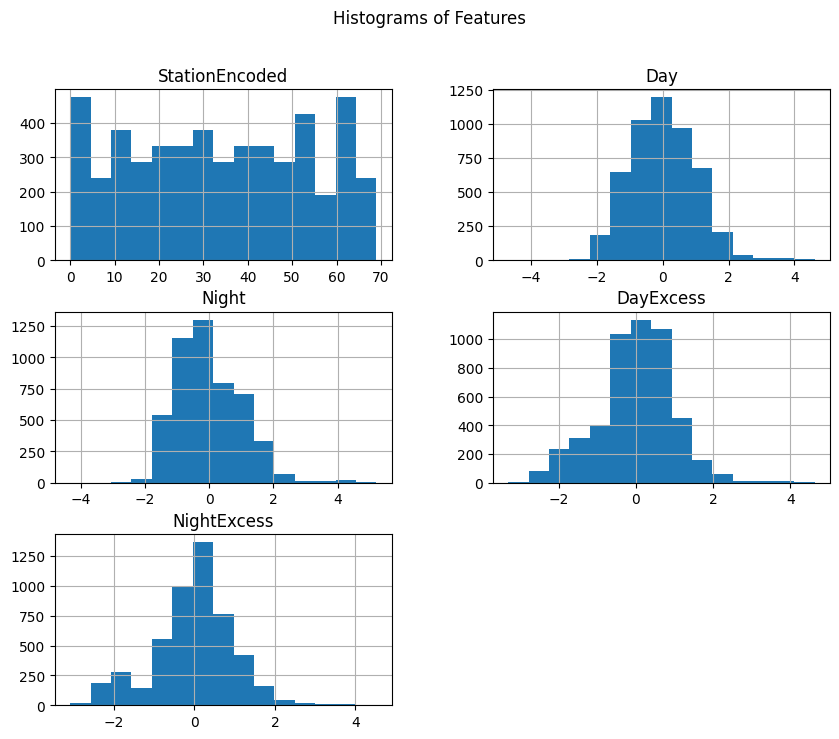

In [20]:
# Histogram for each feature
df_model.hist(figsize=(10, 8), bins=15)
plt.suptitle("Histograms of Features")
plt.show()


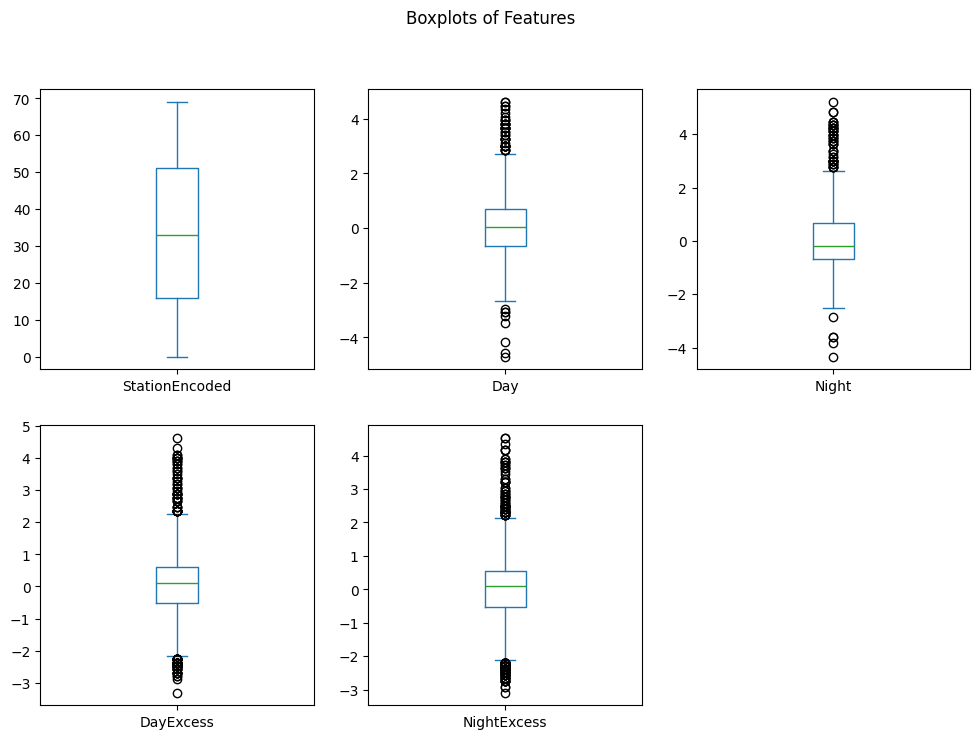

In [21]:
# Boxplots for each feature
df_model.plot(kind='box', subplots=True, layout=(2,3), figsize=(12,8), sharex=False, sharey=False)
plt.suptitle("Boxplots of Features")
plt.show()

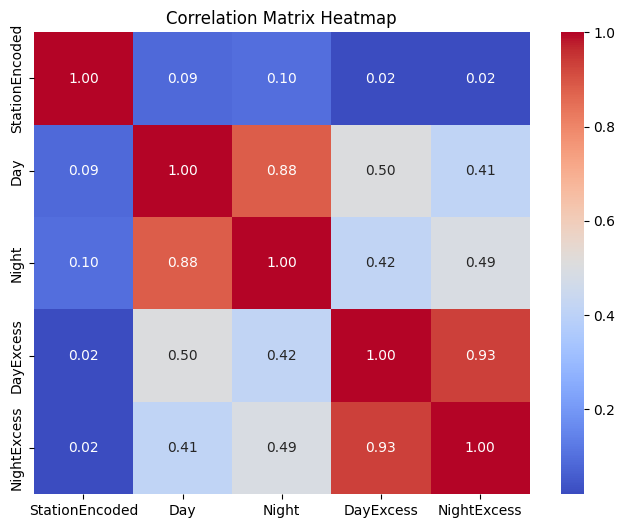

In [22]:
# Correlation matrix and heatmap
corr = df_model.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()